# <center> Evaluate model performance on the testset </center>


In [1]:
!pip install GitPython
from git import Repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.9 MB/s eta 0:00:00


In [2]:
!pip install wget wfdb neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=742d80ca4f340c3e53b2da9cc0e988cbda609b8f567dc7f974081340838fb9ed
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1


In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json'

kaggle.json
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [15]:
!kaggle datasets download -d bjoernjostein/ptbxl-electrocardiography-database

100% 1.35G/1.35G [00:52<00:00, 30.5MB/s]
100% 1.35G/1.35G [00:52<00:00, 27.7MB/s]


In [16]:
!kaggle datasets download -d bjoernjostein/physionet-challenge-2021-snomed-mappings

  0% 0.00/4.13k [00:00<?, ?B/s]
100% 4.13k/4.13k [00:00<00:00, 4.53MB/s]


In [17]:
HTTPS_REMOTE_URL = 'https://github.com/Bsingstad/ECG-age.git'
DEST_NAME = 'ecg_age'
cloned_repo = Repo.clone_from(HTTPS_REMOTE_URL, DEST_NAME)

GitCommandError: ignored

In [18]:
import os, zipfile

dir_name = "./"
extension = ".zip"
 
os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [20]:
import shutil
import os
os.mkdir("/content/ecg_age/data")
sources = ["WFDB/"]
dest1 = '/content/ecg_age/data/'


for s in sources:
  files = os.listdir(s)
  for f in files:
      shutil.move(s+f, dest1)

In [21]:
from ecg_age.src.helpers.helpers import *
from ecg_age.src.models.models import *
from ecg_age.src.ECGfeaturizer import featurize as ef

In [22]:
import pandas as pd
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
select_gender="both"

In [24]:
######################################################
print("Collecting labels, ECG filenames and metadata...")
gender, age, labels, ecg_len, ecg_filenames = import_key_data("/content/ecg_age/data/")
ecg_filenames = np.asarray(ecg_filenames)
age = np.asarray(age)
gender = np.asarray(gender)
ecg_len = np.asarray(ecg_len)
labels = np.asarray(labels)
print(f"Total number of patients found: {len(age)}")

100%|██████████| 43674/43674 [00:07<00:00, 5634.86it/s]


Total number of patients found: 21837


In [25]:
#####################################################
print("remove all ECGs not equal to 10 seconds")
age, gender,ecg_filenames, labels = only_ten_sec(ecg_len, age, gender, ecg_filenames, labels)

remove all ECGs not equal to 10 seconds


In [26]:
print("remove all ECGs with missing values in gender or age")
ecg_filenames, gender, age, labels = remove_nan_and_unknown_values(ecg_filenames, gender, age, labels)

remove all ECGs with missing values in gender or age


In [27]:
age = clean_up_age_data(age)
gender = clean_up_gender_data(gender)

print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 21748


In [28]:
print("Select ECGs from males or females")
if select_gender != "both":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g=select_gender)
else:
    pass

Select ECGs from males or females


In [29]:
print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 21748


In [ ]:
samp_freq = 100
time = 10
num_leads = 12
batchsize = 16
epoch = 20
mae_score_total = []

#choosing the model
#model = attia_network_age(samp_freq,time,num_leads) # velg modell
model = build_model((samp_freq*time,num_leads), 1)


#change the name of the weights file as needed, according to the model and gender chosen
if select_gender == "female":
  model.load_weights("/content/ecg_age/model_weights/model_weights_inception_female.h5")
elif select_gender == "male":
  model.load_weights("/content/ecg_age/model_weights/model_weights_inception_male.h5")
elif select_gender == "both":
  model.load_weights("/content/ecg_age/model_weights/model_weights_balanced_training_inceptionboth.h5")
  print("adding weights for both genders")

mse_score = []
mae_score = []
f1_score = []
acc_score = []
pred_age = []
true_age = []
for indx in tqdm.tqdm(range(len(ecg_filenames))):
    data, header_data = load_challenge_data(ecg_filenames[indx])
    if int(header_data[0].split(" ")[2]) != samp_freq:
        data_new = np.ones([num_leads,int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*samp_freq)])
        for k,l in enumerate(data):
            data_new[k] = signal.resample(l, int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*samp_freq))
        data = data_new
        data = pad_sequences(data, maxlen=samp_freq*10, truncating='post',padding="post")
    data = np.moveaxis(data, 0, -1)

    y_true = age[indx]
    true_age.append(y_true)
    y_hat = model.predict(np.expand_dims(data, axis=0), verbose=0)
    pred_age.append(y_hat)
    mse_score.append(mean_squared_error(np.expand_dims(y_true,axis=0),y_hat.ravel()))
    mae_score.append(mean_absolute_error(np.expand_dims(y_true,axis=0),y_hat.ravel()))
mse_score = np.asarray(mse_score).mean()
mae_score = np.asarray(mae_score).mean()
print("MAE score {}".format(mae_score))
print("MSE score {}".format(mse_score))
mae_score_total.append(mae_score)


In [31]:
samp_freq = 100
time = 10
num_leads = 12
batchsize = 16
epoch = 20
mae_score_total = []

#choosing the model
#model = attia_network_age(samp_freq,time,num_leads) # velg modell
model = build_model((samp_freq*time,num_leads), 1)


#change the name of the weights file as needed, according to the model and gender chosen
if select_gender == "female":
  model.load_weights("/content/ecg_age/model_weights/model_weights_inception_female.h5")
elif select_gender == "male":
  model.load_weights("/content/ecg_age/model_weights/model_weights_inception_male.h5")
elif select_gender == "both":
  model.load_weights("/content/ecg_age/model_weights/model_weights_balanced_training_inceptionboth.h5")
  print("adding weights for both genders")

mse_score = []
mae_score = []
f1_score = []
acc_score = []
pred_age = []
true_age = []
all_data = []
for indx in tqdm.tqdm(range(len(ecg_filenames))):
    data, header_data = load_challenge_data(ecg_filenames[indx])
    if int(header_data[0].split(" ")[2]) != samp_freq:
        data_new = np.ones([num_leads,int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*samp_freq)])
        for k,l in enumerate(data):
            data_new[k] = signal.resample(l, int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*samp_freq))
        data = data_new
        data = pad_sequences(data, maxlen=samp_freq*10, truncating='post',padding="post")
    data = np.moveaxis(data, 0, -1)
    all_data.append(data)
    y_true = age[indx]
    true_age.append(y_true)
all_data = np.asarray(all_data)    
y_hat = model.predict(all_data, verbose=0)
true_age = np.asarray(true_age)

adding weights for both genders


100%|██████████| 21748/21748 [01:12<00:00, 299.74it/s]


In [32]:
mse = mean_squared_error(true_age,y_hat.ravel())
mae = mean_absolute_error(true_age,y_hat.ravel())
print("MAE score {}".format(mse))
print("MSE score {}".format(mae))


MAE score 126.91813139082772
MSE score 8.760563005983599


In [ ]:
print("mean MAE score {}".format(np.asarray(mae_score_total).mean()))
print("std MAE score {}".format(np.asarray(mae_score_total).std()))

mean MAE score 8.288635834802133
std MAE score 0.0


In [35]:
d = {"True age": np.asarray(true_age).ravel(), 'Predicted age': np.asarray(y_hat).ravel(),'Error': abs(np.asarray(true_age).ravel() - np.asarray(y_hat).ravel())}
df = pd.DataFrame(data = d)

## Analysis:


In [ ]:
ecg[1,:].shape

(5000,)

In [ ]:
rr = []
pr = []
qt = []
for indx in tqdm.tqdm(range(len(ecg_filenames))):
    ecg, _ = load_challenge_data(ecg_filenames[indx])
    featurizer = ef.get_features(ecg[1,:], 500)
    try:
      a,b,c = featurizer.calc_intervals()
    except:
      a = np.nan
      b = np.nan
      c = np.nan
    rr.append(np.mean(a))
    pr.append(np.mean(b))
    qt.append(np.mean(c))

100%|██████████| 10387/10387 [32:58<00:00,  5.25it/s]


In [ ]:
len(rr)

10387

In [ ]:
df["RRinterval"] = rr
df["PRinterval"] = pr
df["QTinterval"] = qt

In [ ]:
import seaborn as sns

In [ ]:
df = df.dropna()

In [ ]:
df = df.drop(df.index[df['QTinterval'] < 0])
df = df.drop(df.index[df['QTinterval'] > 1])

In [ ]:
df = df.drop(df.index[df['PRinterval'] < 0])
df = df.drop(df.index[df['PRinterval'] > 0.3])

In [ ]:
df = df.drop(df.index[df['RRinterval'] < 0])
df = df.drop(df.index[df['RRinterval'] > 1.5])

<Figure size 1440x1440 with 0 Axes>

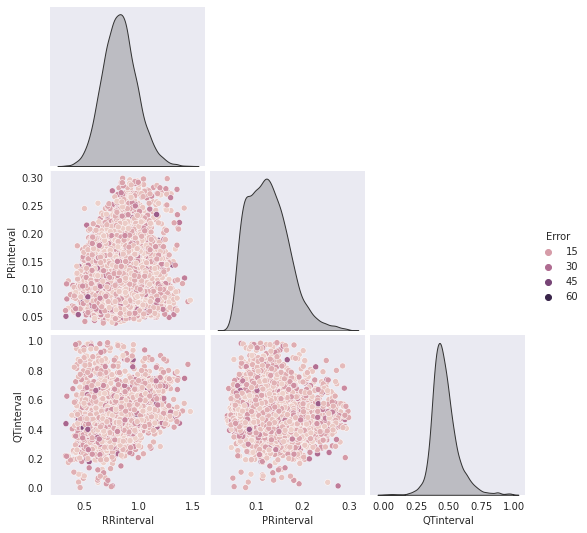

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(df.iloc[:,2:], hue="Error", diag_kws=dict(color=".2", hue=None), corner=True)
plt.show()

### Comparing the predicted age vs the acual age. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

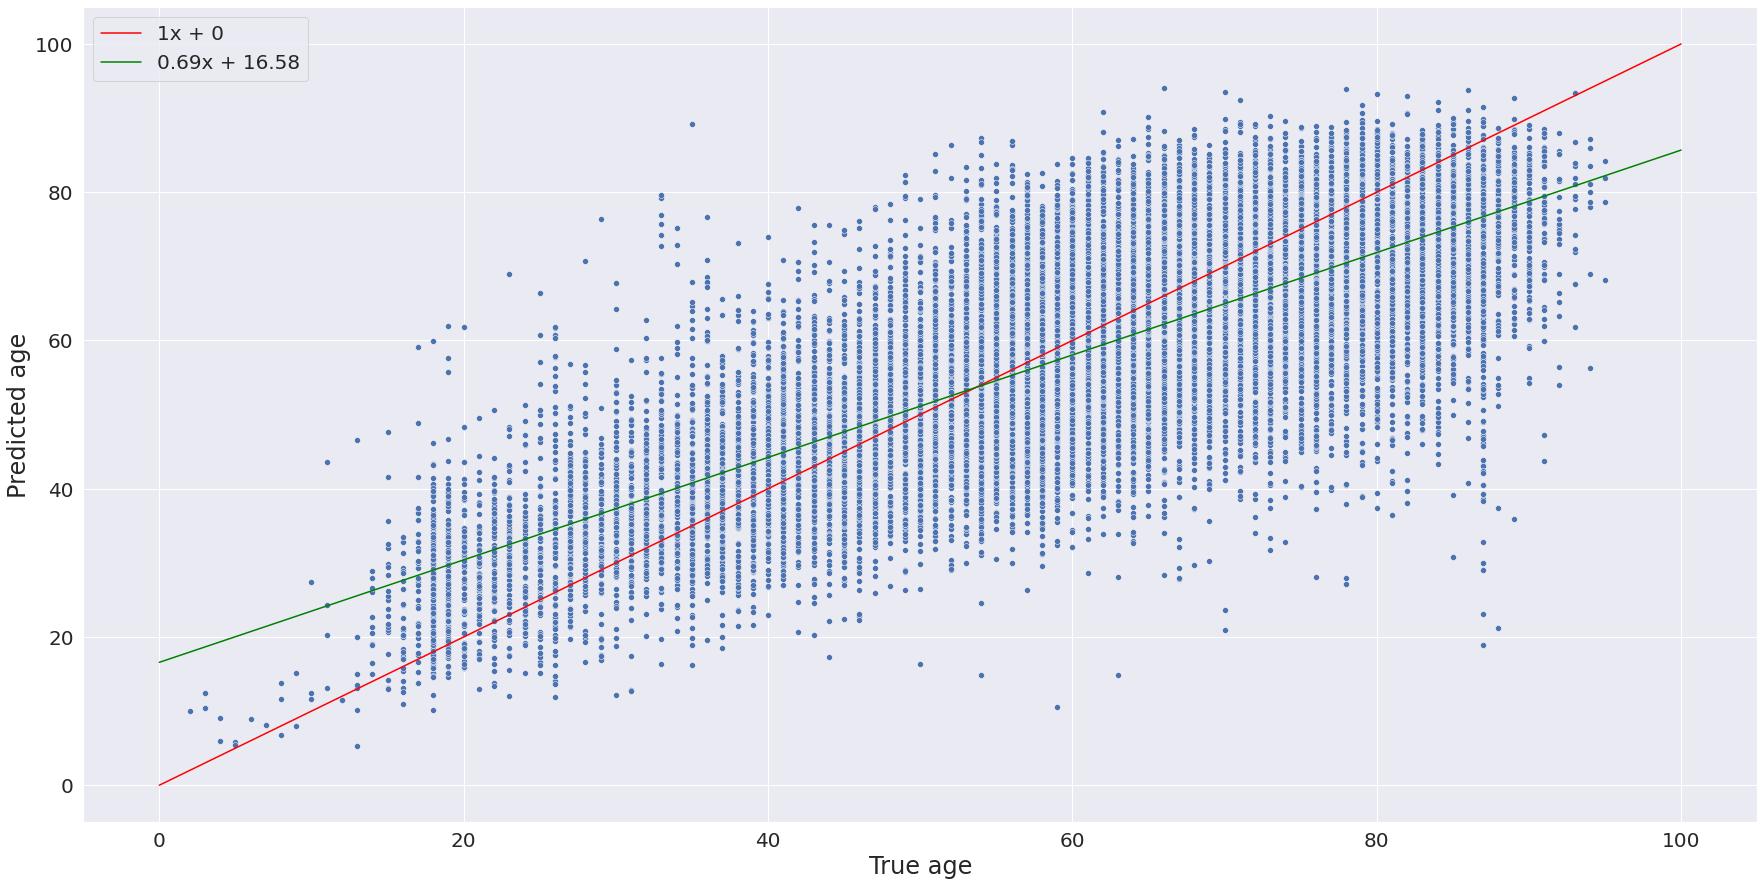

In [36]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["True age"],df["Predicted age"])
reg_line = (np.arange(101)*slope) + intercept
plt.figure(figsize=(30,15))
sns.set(font_scale=2)
sns.scatterplot(data=df, x="True age", y="Predicted age")
sns.set(font_scale=5)
plt.plot(np.arange(101),'red', label="1x + 0")
plt.plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
snomed_ct_codes = np.array(["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","164909002","251146004","698252002","426783006","284470004",
 "10370003","365413008","427172004","164947007","111975006","164917005","47665007","59118001","427393009","426177001","427084000","63593006","164934002","59931005","17338001"])


In [ ]:
diagnoses = np.array(["atrial fibrillation","atrial flutter","bundle branch block","bradycardia","complete left bundle branch block","complete right bundle branch block","1st degree av block","incomplete right bundle branch block","left axis deviation","left anterior fascicular block",
"left bundle branch block","low qrs voltages","nonspecific intraventricular conduction disorder","sinus rhythm","premature atrial contraction","pacing rhythm","poor R wave Progression","premature ventricular contractions","prolonged pr interval","prolonged qt interval",
"qwave abnormal","right axis deviation","right bundle branch block","sinus arrhythmia","sinus bradycardia","sinus tachycardia","supraventricular premature beats","t wave abnormal","t wave inversion","ventricular premature beats"])


In [ ]:
val_ecg_filenames =np.asarray(ecg_filenames)

In [ ]:
classes = set()
for ecg_file in tqdm.tqdm(val_ecg_filenames):
    header_file = ecg_file.replace('.mat','.hea')
    header = load_header(header_file)
    classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
else:
    classes = sorted(classes) # Sort classes alphanumerically if not numbers.
num_classes = len(classes)

100%|██████████| 21748/21748 [00:00<00:00, 37882.92it/s]


In [ ]:
scored_classes = []
for i in classes:
    for j in snomed_ct_codes:
        if i == '':
            continue
        if i == j:
            scored_classes.append(i)
scored_classes = sorted(scored_classes)

In [ ]:
class_names = []
for j in range(len(scored_classes)):
    for i in range(len(snomed_ct_codes)):
        if (str(snomed_ct_codes[i]) == scored_classes[j]):
            class_names.append(diagnoses[i])

In [ ]:
num_recordings = len(val_ecg_filenames)
num_classes = len(scored_classes)
val_labels = np.zeros((num_recordings, num_classes), dtype=np.bool) # One-hot encoding of classes

for i in range(len(val_ecg_filenames)):
    current_labels = get_labels(load_header(val_ecg_filenames[i].replace('.mat','.hea')))
    for lab in current_labels:
        if lab in scored_classes:
            j = scored_classes.index(lab)
        val_labels[i, j] = 1
val_labels = val_labels * 1

### Comparing the predicted age vs the actual age for 30 different cardiovascular diseases. The red line shows the correct age, while the green line shows the result of the best linear fit based on the predicted age

In [ ]:
my_mae = []
for i in range(20):
  MAE = np.asarray(abs(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])).sum()/len(np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]))
  my_mae.append(MAE)
new_ind = np.argsort(my_mae)

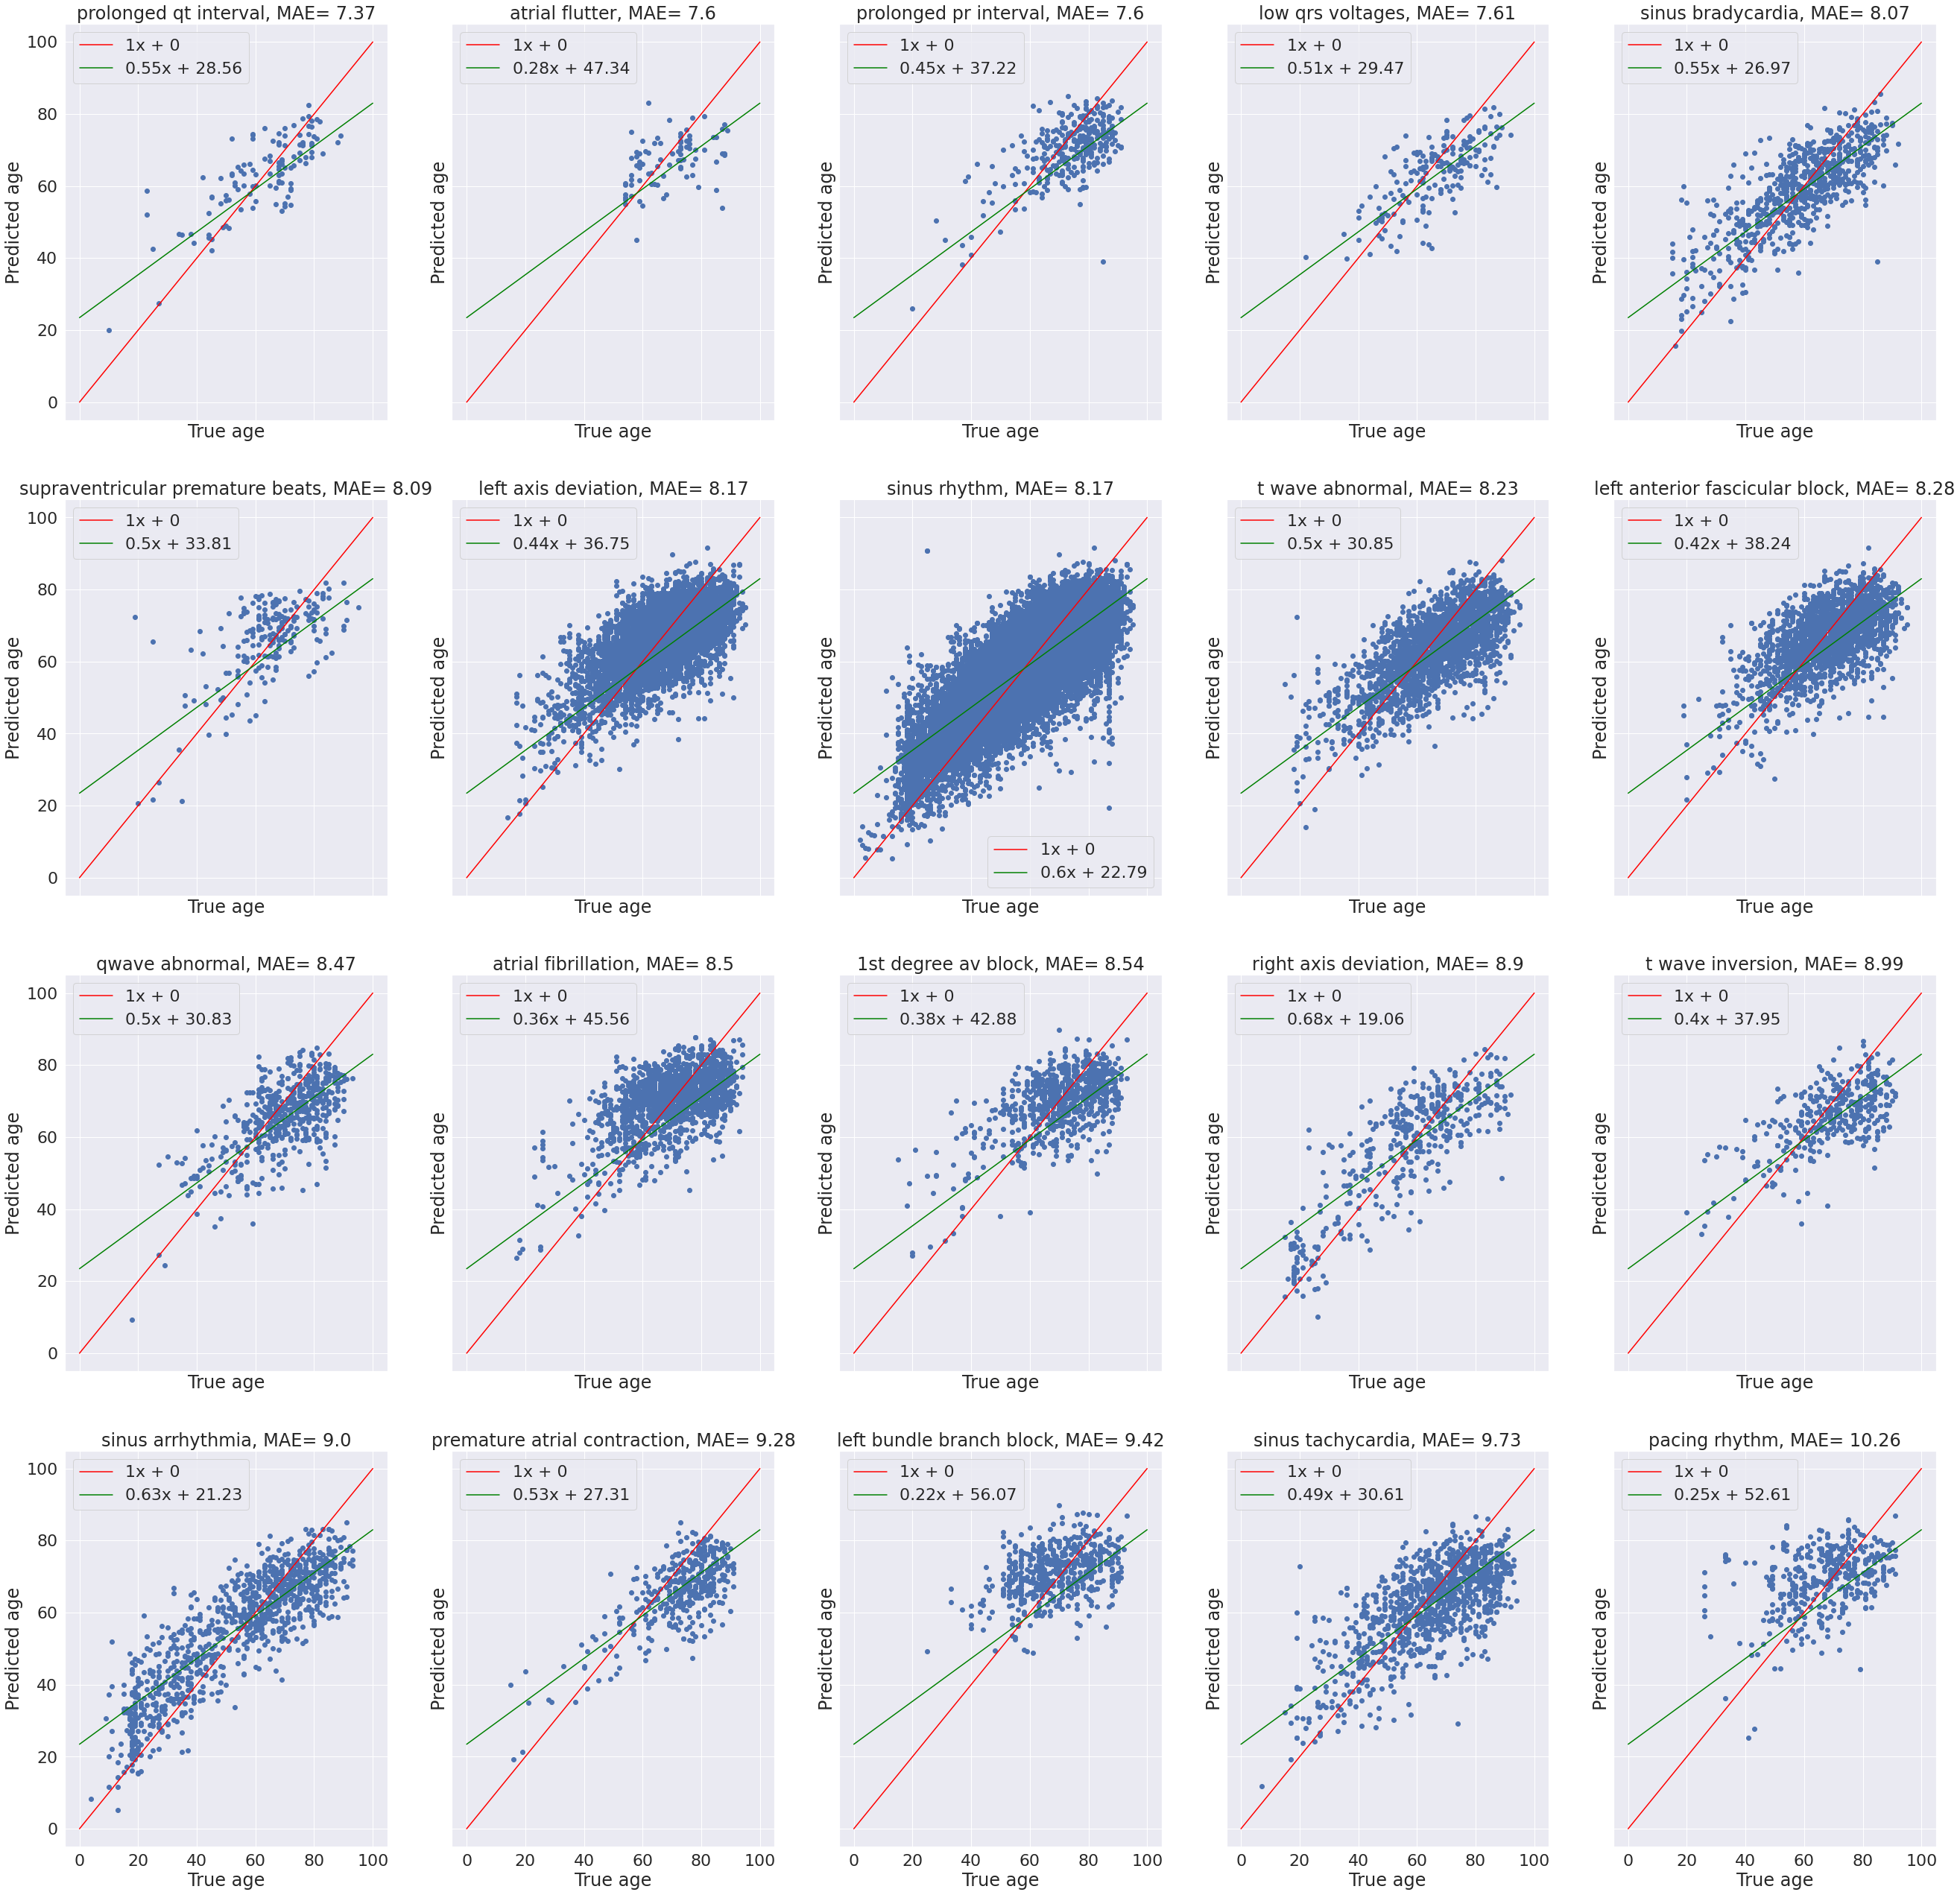

In [ ]:
fig, ax = plt.subplots(4, 5, sharex=True, sharey=True)
fig.set_figheight(45)
fig.set_figwidth(45)
cnt = 0
cnt_2 = 0
for i in new_ind:
    sns.set(font_scale=2)
    TE = np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]).sum()
    MAE = np.asarray(abs(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])).sum()/len(np.asarray(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"] - df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.iloc[np.where(val_labels[:,i]==1)[0]]["True age"],df.iloc[np.where(val_labels[:,i]==1)[0]]["Predicted age"])
    ax[cnt_2,cnt].set_title(class_names[i]+ ", MAE= {}".format(round(MAE,2)))
    df_temp = df.iloc[np.where(val_labels[:,i]==1)[0]]
    ax[cnt_2,cnt].scatter(df_temp["True age"],df_temp["Predicted age"])
    #sns.scatterplot(data=df.iloc[np.where(val_labels[:,i]==1)[0]], x="True age", y="Predicted age")
    ax[cnt_2,cnt].plot(np.arange(101),'red', label="1x + 0")
    ax[cnt_2,cnt].plot(reg_line,'green', label = "{}x + {}".format(round(slope,2), round(intercept,2)))
    ax[cnt_2,cnt].set_xlabel("True age")
    ax[cnt_2,cnt].set_ylabel("Predicted age")
    ax[cnt_2,cnt].legend()
    cnt += 1
    if cnt == 5:
        cnt_2 += 1
        cnt = 0
fig.savefig("revised_diagnoseplot.png",dpi=300, bbox_inches='tight')

